# Detector distortion corrections

This tutorial shows how to correct images for spatial distortion. Some tutorial examples rely on files available in http://www.silx.org/pub/pyFAI/testimages/ and will be downloaded during this tutorial. The required minimum version of pyFAI is 0.12.0.

## Detector definitions

PyFAI features an impressive list of 64 detector definitions contributed often by manufacturers and some other reverse engineerd by scientists. 
Each of them is defined as an invividual class which contains a way to calculate the mask (invalid pixels, gaps,…) and a method to calculate the pixel positions in Cartesian coordinates. 


In [1]:
import time, os
start_time = time.perf_counter()

#Nota: If you are behind a proxy/firewall this can help you
#os.environ["http_proxy"] = "http://proxy.company.com:3128"

import pyFAI, pyFAI.detectors
print("pyFAI version: %s"% pyFAI.version)
all_detectors = list(set(pyFAI.detectors.ALL_DETECTORS.values()))
#Sort detectors according to their name
all_detectors.sort(key=lambda i:i.__name__)
nb_det = len(all_detectors)
print("Number of detectors registered: %i with %i unique detectors"%(len(pyFAI.detectors.ALL_DETECTORS),nb_det))
print()
print("List of all supported detectors:")
for i in all_detectors:
    print(i())

pyFAI version: 0.20.0-beta1
Number of detectors registered: 238 with 82 unique detectors

List of all supported detectors
Detector Quantum 210	 Spline= None	 PixelSize= 5.100e-05, 5.100e-05 m
Detector Quantum 270	 Spline= None	 PixelSize= 6.480e-05, 6.480e-05 m
Detector Quantum 315	 Spline= None	 PixelSize= 5.100e-05, 5.100e-05 m
Detector Quantum 4	 Spline= None	 PixelSize= 8.200e-05, 8.200e-05 m
Detector Aarhus	 Spline= None	 PixelSize= 2.489e-05, 2.489e-05 m
Detector ApexII	 PixelSize= 1.200e-04, 1.200e-04 m
Detector aca1300	 PixelSize= 3.750e-06, 3.750e-06 m
Detector CirPAD	 PixelSize= 1.300e-04, 1.300e-04 m
Undefined detector
Detector Dexela 2923	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger 16M	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger 1M	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger2 CdTe 16M	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger2 CdTe 1M	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger2 CdTe 1M-W	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger2 CdT

## Defining a detector from a spline file 
For optically coupled CCD detectors, the geometrical distortion is often described by a two-dimensional cubic spline (as in FIT2D) which can be imported into the relevant detector instance and used to calculate the actual pixel position in space (and masked pixels).

At the ESRF, mainly FReLoN detectors [J.-C. Labiche, ESRF Newsletter 25, 41 (1996)] are used with spline files describing the distortion of the fiber optic taper.

Let's download such a file and create a detector from it. Users at ESRF may declare a proxy to connect to the internet. 

In [2]:
import os
from silx.resources import ExternalResources
downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/testimages", "PYFAI_DATA")
spline_file = downloader.getfile("halfccd.spline")
print(spline_file)

/tmp/pyFAI_testdata_jerome/halfccd.spline


In [3]:
hd = pyFAI.detectors.FReLoN(splineFile=spline_file)
print(hd)
print("Shape: %i, %i"% hd.shape)

Detector FReLoN	 Spline= /tmp/pyFAI_testdata_jerome/halfccd.spline	 PixelSize= 4.842e-05, 4.684e-05 m
Shape: 1025, 2048


*Note:* the unusual shape of this detector. This is probably a human error when calibrating the detector distortion in FIT2D.

### Visualizing the mask
Every detector object contains a mask attribute, defining pixels which are invalid. 
For FReLoN detector (a spline-files-defined detectors), all pixels having an offset such that the pixel falls out of the initial detector are considered as invalid. 

Masked pixel have non-null values can be displayed like this: 

In [4]:
%pylab nbagg
from pyFAI.gui import jupyter

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


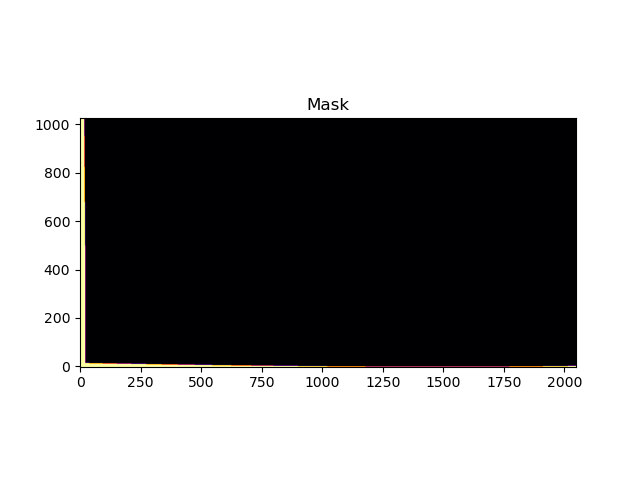

In [5]:
jupyter.display(hd.mask, label="Mask")
pass


## Detector definition files as NeXus files

Any detector object in pyFAI can be saved into an HDF5 file following the NeXus convention [Könnecke et al., 2015, J. Appl. Cryst. 48, 301-305.]. Detector objects can subsequently be restored from disk, making complex detector definitions less error prone. 

In [6]:
h5_file = "halfccd.h5"
hd.save(h5_file)
new_det = pyFAI.detector_factory(h5_file)
print(new_det)
print("Mask is the same: ", numpy.allclose(new_det.mask, hd.mask))
print("Pixel positions are the same: ", numpy.allclose(new_det.get_pixel_corners(), hd.get_pixel_corners()))
print("Number of masked pixels", new_det.mask.sum())

FReLoN detector from NeXus file: halfccd.h5	 PixelSize= 4.842e-05, 4.684e-05 m
Mask is the same:  True
Pixel positions are the same:  True
Number of masked pixels 34382


Pixels of an area detector are saved as a four-dimensional dataset: i.e. a two-dimensional array of vertices pointing to every corner of each pixel, generating an array of dimension (Ny, Nx, Nc, 3), where Nx and Ny are the dimensions of the detector, Nc is the number of corners of each pixel, usually four, and the last entry contains the coordinates of the vertex itself (in the order: Z, Y, X). 

This kind of definition, while relying on large description files, can address some of the most complex detector layouts. They will be presented a bit later in this tutorial.

In [7]:
print("Size of Spline-file:", os.stat(spline_file).st_size)
print("Size of Nexus-file:", os.stat(h5_file).st_size)

Size of Spline-file: 1183
Size of Nexus-file: 42908890


The HDF5 file is indeed much larger than the spline file. 

## Modify a detector and saving

One may want to define a new mask (or flat-field) for its detector and save the mask with the detector definition. 
Here, we create a copy of the detector and reset its mask to enable all pixels in the detector and save the new  detector instance into another file.

In [8]:
import copy
nomask_file = "nomask.h5"
nomask = copy.deepcopy(new_det)
nomask.mask = numpy.zeros_like(new_det.mask)
nomask.save(nomask_file)
nomask = pyFAI.detector_factory("nomask.h5")
print("No pixels are masked",nomask.mask.sum())

No pixels are masked 0


**Wrap up**

In this section we have seen how detectors are defined in pyFAI, how they can be created, either from the list of the parametrized ones, or from spline files, or from NeXus detector files. 
We have also seen how to save and subsequently restore a detector instance, preserving the modifications made.

## Distortion correction

Once the position of every single pixel in space is known, one can benefit from the regridding engine of pyFAI adapted to image distortion correction tasks. 
The *pyFAI.distortion.Distortion* class is the equivalent of the *pyFAI.AzimuthalIntegrator* for distortion. 
Provided with a detector definition, it enables the correction of a set of images by using the same kind of look-up tables as for azimuthal integration.

In [9]:
from pyFAI.distortion import Distortion
dis = Distortion(nomask)
print(dis)

Distortion correction csr on device None for detector shape (1025, 2048):
FReLoN detector from NeXus file: nomask.h5	 PixelSize= 4.842e-05, 4.684e-05 m


### FReLoN detector

First load the image to be corrected, then correct it for geometric distortion.


<IPython.core.display.Javascript object>


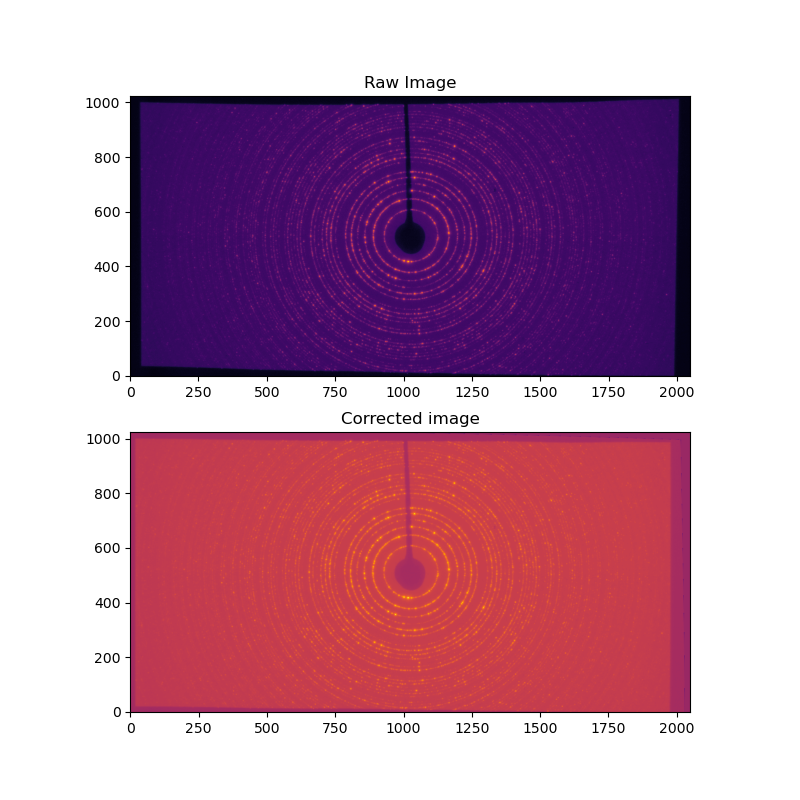

In [10]:
halfccd_img = downloader.getfile("halfccd.edf")
import fabio
raw = fabio.open(halfccd_img).data
cor = dis.correct(raw, dummy=raw.min())

#Then display raw and corrected imagesimages 
fig, ax = subplots(2, figsize=(8,8))

jupyter.display(raw, label="Raw Image", ax=ax[0])
jupyter.display(cor, label="Corrected image", ax=ax[1])
pass

**Nota:** in this case the image size (1024 lines) does not match the detector's number of lines (1025) hence pyFAI complains about it. 
Here, pyFAI patched the image on an empty image of the right size so that the processing can occur. 

In this example, the size of the pixels and the shape of the detector are preserved, discarding all pixels falling outside the detector's grid. 

One may want all pixels' intensity to be preserved in the transformation. By allowing the output array to be large enough to accomodate all pixels, the total intensity can be kept. For this, just enable the "resize" option in the constructor of *Distortion*:

In [11]:
dis1 = Distortion(hd, resize=True)
cor = dis1.correct(raw)
print(dis1)
print("After correction, the image has a different shape", cor.shape)

Distortion correction csr on device None for detector shape (1045, 2052):
Detector FReLoN	 Spline= /tmp/pyFAI_testdata_jerome/halfccd.spline	 PixelSize= 4.842e-05, 4.684e-05 m
After correction, the image has a different shape (1045, 2052)


<IPython.core.display.Javascript object>


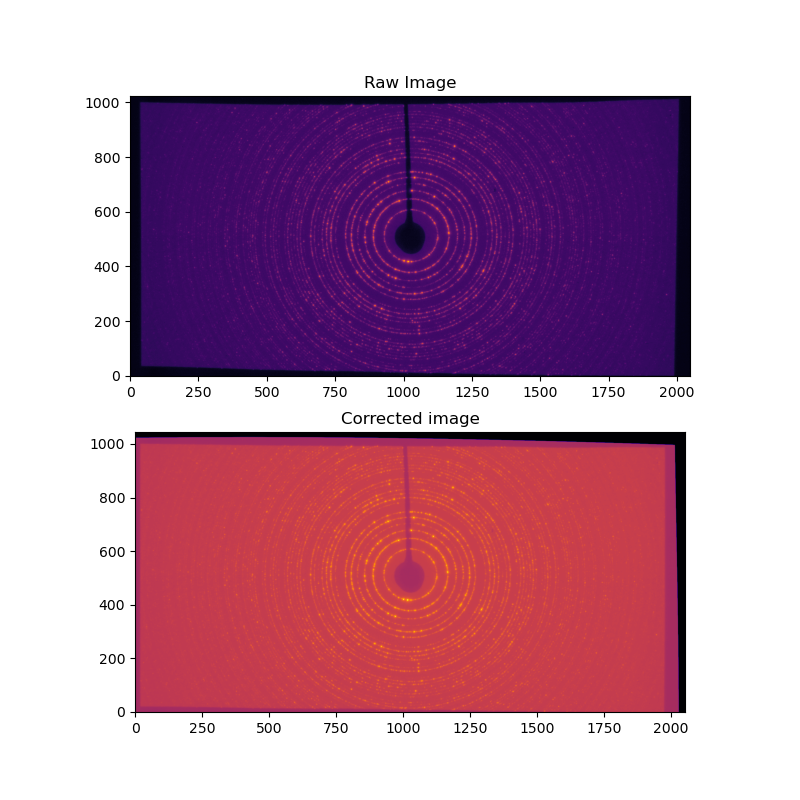

In [12]:
fig, ax = subplots(2,figsize=(8,8))
jupyter.display(raw, label="Raw Image", ax=ax[0])
jupyter.display(cor, label="Corrected image", ax=ax[1])
pass

### Example of Pixel-detectors: 

#### XPad Flat detector

There is a striking example in the cover image of this article: http://scripts.iucr.org/cgi-bin/paper?S1600576715004306 where a detector made of multiple modules is *eating up* some rings. 
The first example will be about the regeneration of an "eyes friendly" version of this image.

Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Shape as input and output: (960, 560) (1153, 578)
Conservation of the total intensity: 11120798.0 11120798.01254736


<IPython.core.display.Javascript object>


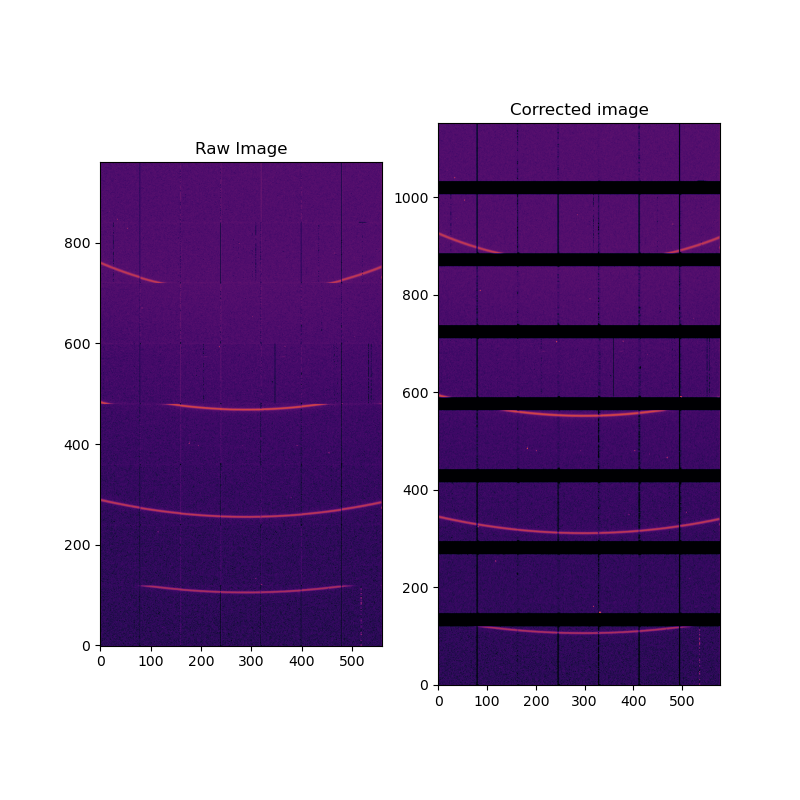

In [13]:
xpad_file = downloader.getfile("LaB6_18.57keV_frame_13.edf")
xpad = pyFAI.detector_factory("Xpad_flat")
print(xpad)
xpad_dis = Distortion(xpad, resize=True)

raw = fabio.open(xpad_file).data
cor = xpad_dis.correct(raw)
print("Shape as input and output:", raw.shape, cor.shape)
print("Conservation of the total intensity:", raw.sum(dtype="float64"), cor.sum(dtype="float64"))

#then display images side by side
fig, ax = subplots(1, 2, figsize=(8,8))
jupyter.display(raw, label="Raw Image", ax=ax[0])
jupyter.display(cor, label="Corrected image", ax=ax[1])
pass

#### WOS XPad detector

This is a new **WAXS opened for SAXS** pixel detector from ImXPad (available at ESRF-BM02/D2AM CRG beamline). 
It looks like two of *XPad_flat* detectors side by side with some modules shifted in order to create a hole to accomodate a flight-tube which gathers the SAXS photons to a second detector further away.

The detector definition for this specific detector has directly been put down using the metrology informations from the manufacturer and saved as a NeXus detector definition file. 


NexusDetector detector from NeXus file: /tmp/pyFAI_testdata_jerome/WOS.h5	 PixelSize= 1.300e-04, 1.300e-04 m
Shape as input: (598, 1154) and output: (710, 1302)
Conservation of the total intensity: 4.4436e+08 vs 4.4436e+08 


<IPython.core.display.Javascript object>


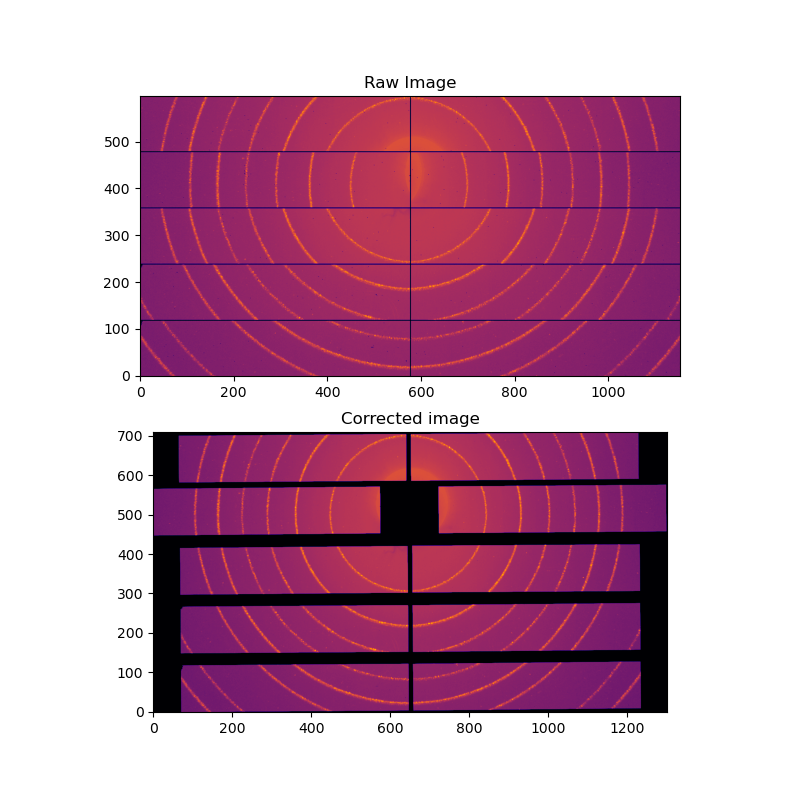

In [14]:
wos_det = downloader.getfile("WOS.h5")
wos_img = downloader.getfile("WOS.edf")
wos = pyFAI.detector_factory(wos_det)
print(wos)
wos_dis = Distortion(wos, resize=True)

raw = fabio.open(wos_img).data
cor = wos_dis.correct(raw)
print("Shape as input: %s and output: %s"%( raw.shape, cor.shape))
print("Conservation of the total intensity: %.4e vs %.4e "%(raw.sum(dtype="float64"), cor.sum(dtype="float64")))
#then display images side by side
fig, ax = subplots(2, figsize=(8,8))
jupyter.display(raw, label="Raw Image", ax=ax[0])
jupyter.display(cor, label="Corrected image", ax=ax[1])
pass

**Nota:** Do not use this detector definition file to process data from the WOS@D2AM as it has not (yet) been fully validated and may contain some errors in the pixel positioning.

## Conclusion

PyFAI provides a very comprehensive list of detector definitions, is versatile enough to address most area detectors on the market, and features a powerful regridding engine, both combined together into the distortion correction tool which ensures the conservation of the signal during the transformation (the number of photons counted is preserved during the transformation)

Distortion correction should not be used for pre-processing images prior to azimuthal integration as it re-bins the image, thus induces a broadening of the peaks. The AzimuthalIntegrator object performs all this together with integration, it has hence a better precision.

This tutorial did not answer the question *how to calibrate the distortion of a given detector ?* which is addressed in another tutorial called **detector calibration**.

In [15]:
print(f"Total execution time: {time.perf_counter() - start_time:.3f} s")

Total execution time: 8.999 s
